In [1]:
import xarray as xr

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats





#tangential accel

ymin = -80.
ymax =  80.
ylabel = "Tangential Acceleration"
xlabelString = "Quantiles of Conditional Tangental Acceleration"

fileName = 'tang_ASO_atl_0_90.nc'
output1  = "tang_scatter_ASO_atl_0_90.png"
output2  = "tang_beta_ASO_atl_0_90.png"

# 20-40N
fileName = 'tang_ASO_atl_20_40.nc'
output1 = "tang_scatter_ASO_atl_20_40.png"
output2 = "tang_beta_ASO_atl_20_40.png"


fileName = 'tang_ALL_atl_20_40.nc'
output1 = "tang_scatter_ALL_atl_20_40.png"
output2 = "tang_beta_ALL_atl_20_40.png"


fileName = 'tang_JASO_atl_20_40.nc'
output1 = "tang_scatter_JASO_atl_20_40.png"
output2 = "tang_beta_JASO_atl_20_40.png"


fileName = 'tang_ALL_atl_30_40.nc'
output1 = "tang_scatter_ALL_atl_30_40.png"
output2 = "tang_beta_ALL_atl_30_40.png"


#---------------------------------------------------
#---------------------------------------------------
#speed
ylabel = "Translation Speed"
ymin = 0.
ymax = 50.
xlabelString = "Quantiles of Conditional Translation Speed"

fileName = 'speed_ASO_atl_20_40.nc'
output1  = "speed_scatter_ASO_atl_20_40.png"
output2  = "speed_beta_ASO_atl_20_40.png"

fileName = 'speed_JASO_atl_20_40.nc'
output1  = "speed_scatter_JASO_atl_20_40.png"
output2  = "speed_beta_JASO_atl_20_40.png"


fileName = 'speed_ASO_atl_0_90.nc'
output1  = "speed_scatter_ASO_atl_0_90.png"
output2  = "speed_beta_ASO_atl_0_90.png"


fileName = './speed_ALL_atl_0_90.nc'
output1 = "speed_scatter_ALL_atl_0_90.png"
output2 = "tang_beta__ALL_atl_0_90.png"

ds = xr.open_dataset(fileName)
print(ds)


<xarray.Dataset>
Dimensions:    (ncl0: 1, ncl1: 1, ncl2: 1, ncl3: 1, ncl5: 38822, ncl6: 38822, ncl7: 54, ncl8: 54, storm: 38822)
Dimensions without coordinates: ncl0, ncl1, ncl2, ncl3, ncl5, ncl6, ncl7, ncl8, storm
Data variables:
    startYear  (ncl0) int32 ...
    endYear    (ncl1) int32 ...
    latS       (ncl2) float32 ...
    latN       (ncl3) float32 ...
    Dates      (storm) datetime64[ns] ...
    Data       (ncl5) float64 ...
    Fracyear   (ncl6) float32 ...
    years      (ncl7) float32 ...
    yearly     (ncl8) float64 ...


In [2]:
Data  = ds.Data
Time  = ds.Fracyear

print(Data.head())
print(Time.head())

<xarray.DataArray 'Data' (ncl5: 5)>
array([12.286803, 12.377501, 12.738096, 13.470362, 14.627024])
Dimensions without coordinates: ncl5
Attributes:
    units:    km/hr
    name:     Speed
<xarray.DataArray 'Fracyear' (ncl6: 5)>
array([1966.4226, 1966.423 , 1966.4233, 1966.4236, 1966.424 ], dtype=float32)
Dimensions without coordinates: ncl6
Attributes:
    calendar:   standard
    long_name:  Time
    units:      YYYY + fractional portion of year
    NCL:        contributed.ncl: function yyyymmddhh_to_yyyyFrac


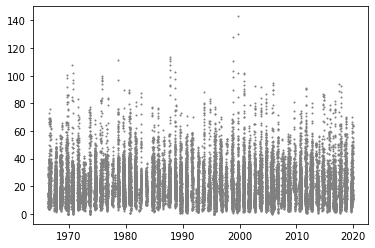

In [3]:
#plt.plot(years, accel, color='grey',markersize=1)
plt.plot(Time, Data,'o', color='grey',markersize=1)


In [4]:
# Linear regression using numpy
slope, intercept, r_value, p_value, std_err = stats.linregress(Time.values,Data.values)
print("R-squared : %f" % r_value**2)
print ("slope    : %f" % slope)
print ("p value  : %f" % p_value)
print ("intercept  : %f" % intercept)


R-squared : 0.000101
slope    : -0.007559
p value  : 0.048164
intercept  : 35.918027


In [5]:
df = pd.DataFrame({'Time':Time, 'Data':Data})
#print(df)

In [6]:
# A frst order polynomial fit to get the linear regression
poly = smf.ols(formula='Data ~ 1 +  Time', data=df).fit()
print (poly.summary())


                            OLS Regression Results                            
Dep. Variable:                   Data   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.904
Date:                Tue, 17 Nov 2020   Prob (F-statistic):             0.0482
Time:                        15:45:35   Log-Likelihood:            -1.5234e+05
No. Observations:               38822   AIC:                         3.047e+05
Df Residuals:                   38820   BIC:                         3.047e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.9180      7.628      4.709      0.0

In [7]:

mod = smf.quantreg('Data ~ Time', df)
result = mod.fit(q=.5)
print(result.summary())
#print (dir(res))

print(result.pvalues['Time'])
print(result.params['Time'])

                         QuantReg Regression Results                          
Dep. Variable:                   Data   Pseudo R-squared:            7.661e-09
Model:                       QuantReg   Bandwidth:                       1.547
Method:                 Least Squares   Sparsity:                        24.70
Date:                Tue, 17 Nov 2020   No. Observations:                38822
Time:                        15:45:36   Df Residuals:                    38820
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.9837      7.693      2.468      0.014       3.905      34.062
Time       -5.643e-05      0.004     -0.015      0.988      -0.008       0.008

The condition number is large, 2.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


In [8]:
#quantiles = np.arange(.05,.96, .05)


quantiles = [0.05,.10,.15,.3,.5,.7,.85,.9,.95]
def fit_model(q):
    res = mod.fit(q=q)
    #print ( q, res.pvalues['Time'])
    return [q, res.params['Intercept'], res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
            
models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])

print(models.round)


<bound method DataFrame.round of       q          a         b         p        lb        ub
0  0.05  31.570190 -0.013072  0.000055 -0.019423 -0.006722
1  0.10  23.543808 -0.008021  0.024229 -0.014997 -0.001045
2  0.15  14.716145 -0.002700  0.464747 -0.009940  0.004539
3  0.30  17.636686 -0.001967  0.614696 -0.009626  0.005692
4  0.50  18.983676 -0.000056  0.988331 -0.007619  0.007506
5  0.70  34.688224 -0.004934  0.335668 -0.014980  0.005111
6  0.85  85.300227 -0.026843  0.000041 -0.039673 -0.014014
7  0.90  85.472280 -0.025133  0.001399 -0.040551 -0.009715
8  0.95   2.966195  0.019804  0.178306 -0.009034  0.048642>


In [9]:
print(models.round(3))


      q       a      b      p     lb     ub
0  0.05  31.570 -0.013  0.000 -0.019 -0.007
1  0.10  23.544 -0.008  0.024 -0.015 -0.001
2  0.15  14.716 -0.003  0.465 -0.010  0.005
3  0.30  17.637 -0.002  0.615 -0.010  0.006
4  0.50  18.984 -0.000  0.988 -0.008  0.008
5  0.70  34.688 -0.005  0.336 -0.015  0.005
6  0.85  85.300 -0.027  0.000 -0.040 -0.014
7  0.90  85.472 -0.025  0.001 -0.041 -0.010
8  0.95   2.966  0.020  0.178 -0.009  0.049


In [10]:
# Least square estimate of the trend of the mean

ols = smf.ols(formula='Data ~ Time', data=df).fit()
ols_ci = ols.conf_int().loc['Time'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Time'],
           lb = ols_ci[0],
           ub = ols_ci[1],
           p=ols.pvalues['Time'])
print(ols)


{'a': 35.91802574000428, 'b': -0.0075594878834514545, 'lb': -0.015057945711200222, 'ub': -6.1030055702687366e-05, 'p': 0.04816436416889622}


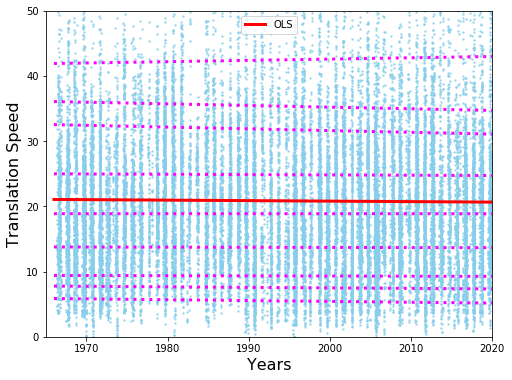

In [11]:
#x = np.arange(df.years.min(), df.years.max(), 50)

x = np.arange(1966,2021,1)

get_y = lambda a, b: a + b * x

n = 9
colors = pl.cm.jet(np.linspace(0,1,n))

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', linewidth=3, color='magenta')

y = get_y(ols['a'], ols['b'])


ax.scatter(df.Time, df.Data, s=2, color='skyblue',alpha=.7)
ax.plot(x, y, color='red', linewidth=3, label='OLS')
ax.set_xlim((1965,2020))
ax.set_ylim((ymin,ymax))

legend = ax.legend()
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel(ylabel, fontsize=16);
plt.savefig(output1)


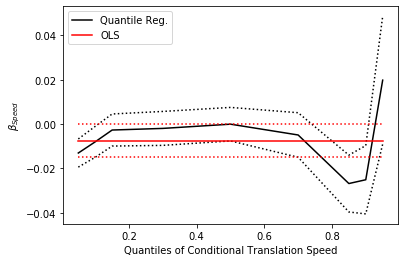

In [12]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{Speed}$')
plt.xlabel(xlabelString)
plt.legend()
#plt.show()
plt.savefig(output2)
